In [2]:
import h5py
import numpy as np
import scipy.signal.windows as wind
import matplotlib.pyplot as plt
from matplotlib import rcParams

#From LIGO website
import readligo as rl

In [3]:
rcParams['figure.figsize'] = (12,8)

# Finding Gravitational Waves!


### Part A:

First want to come up with a noise model for Livingston and Hanford separately.

Loading in the template for the event, as well as the Hanford and Livingston data (comment in which event you want to use!)

In [173]:
fns = ['H-H1_LOSC_4_V2-1126259446-32.hdf5',
       'L-L1_LOSC_4_V2-1126259446-32.hdf5',
       'GW150914_4_template.hdf5']

#fns = ['H-H1_LOSC_4_V2-1128678884-32.hdf5',
#       'L-L1_LOSC_4_V2-1128678884-32.hdf5',
#       'LVT151012_4_template.hdf5']

#fns = ['H-H1_LOSC_4_V2-1135136334-32.hdf5',
#       'L-L1_LOSC_4_V2-1135136334-32.hdf5',
#       'GW151226_4_template.hdf5']

#fns = ['H-H1_LOSC_4_V1-1167559920-32.hdf5',
#       'L-L1_LOSC_4_V1-1167559920-32.hdf5',
#       'GW170104_4_template.hdf5']

In [174]:
data_h_fn = './LOSC_Event_tutorial/' + fns[0]
data_l_fn = './LOSC_Event_tutorial/' + fns[1]
template_fn = './LOSC_Event_tutorial/' + fns[2]

In [175]:
strain_h, time_h, chan_dict_h = rl.loaddata(data_h_fn)
strain_l, time_l, chan_dict_l = rl.loaddata(data_l_fn)
template_datafile = h5py.File(template_fn, "r")

In [176]:
template_h = template_datafile['template'][0]
template_l = template_datafile['template'][1]

Setting the time delta for the data, as well as extracting the corresponding frequency delta (useful when Fourier transforming!). Will be the same for both Livingston and Hanford (I did a sanity check not shown just to make sure!)

In [177]:
dt = time_h[1]-time_h[0]
dnu = 1.0/(dt*len(time_h))
sampling_rate = 1.0/dt

Form the power spectrum for Hanford and Livingston separately

In [178]:
strain_h_ft = np.fft.rfft(strain_h)
strain_l_ft = np.fft.rfft(strain_l)
ps_h = np.abs(strain_h_ft)**2
ps_l = np.abs(strain_l_ft)**2
nu = np.arange(len(strain_h_ft))*dnu

Check out what the power spectra look like

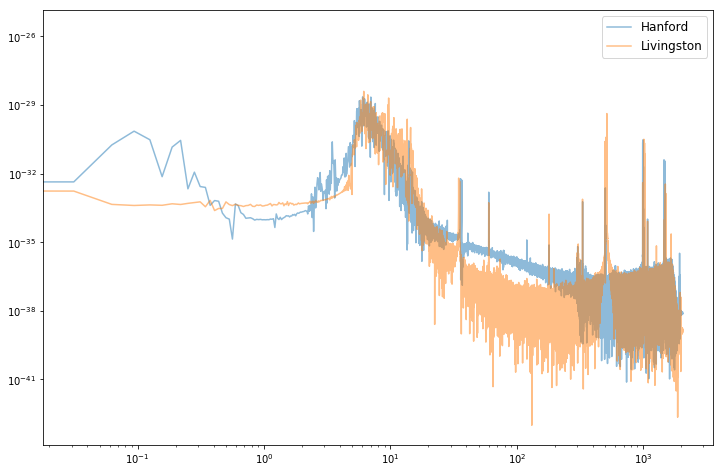

In [179]:
plt.loglog(nu,ps_h,alpha=0.5,label='Hanford')
plt.loglog(nu,ps_l,alpha=0.5,label='Livingston')
plt.legend(fontsize='large')
plt.show()

Make a window function. What might a good choice be? Referencing the windows on https://en.wikipedia.org/wiki/Window_function, going to use the Nuttal window as its fourier transform has low power in the sidelobes. The tradeoff is that the FWHM of the main lobe is wider, so I lose frequency resolution, but the frequency resolution of LIGO is already enough that I don't *think* this should be too big of a deal.

In [180]:
window = wind.nuttall(len(strain_h))

strain_h_ft_w = np.fft.rfft(window*strain_h)
ps_h_w = abs(strain_h_ft_w)**2

strain_l_ft_w = np.fft.rfft(window*strain_l)
ps_l_w = abs(strain_l_ft_w)**2

Check how the window worked at Hanford

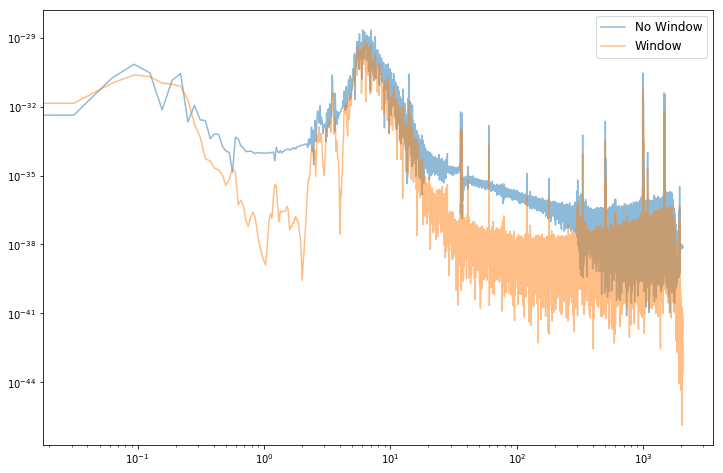

In [210]:
plt.loglog(nu,ps_h,alpha=0.5,label='No Window')
plt.loglog(nu,ps_h_w,alpha=0.5,label='Window')
plt.legend(fontsize='large')
plt.show()

Noise is nicely reduced in the low and high frequencies! Now Livingston

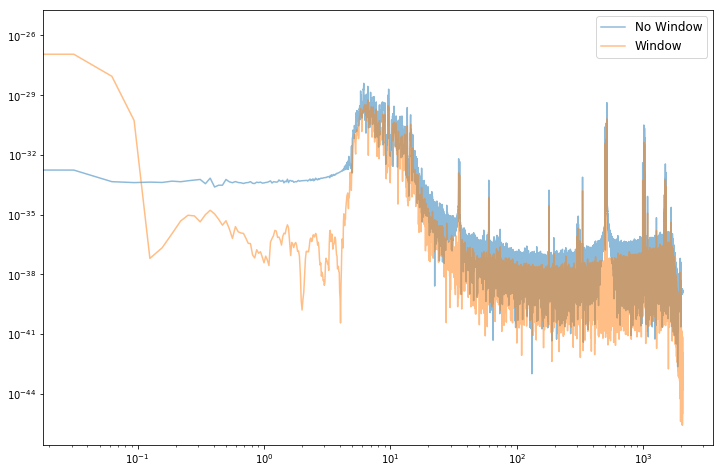

In [211]:
plt.loglog(nu,ps_l,alpha=0.5,label='No Window')
plt.loglog(nu,ps_l_w,alpha=0.5,label='Window')
plt.legend(fontsize='large')
plt.show()

Whoops, a ton of noise got leaked to the very lowest frequencies. This is fine - I'm going to chop off those frequencies anyways because there's not a ton of information in them and its not the frequencies of the signal we're looking for anyways.

What do I need to do now? Need to smooth the data: take the convolution, but do so by multiplying in fourier space.

In [183]:
n = len(ps_h_w)
x = np.arange(n)
fwhm = 30 #30 dt units as fwhm seems reasonable
#Need to centre smoothing function properly for FT reasons
x[int(n/2):] = x[int(n/2):] - n
sigma = fwhm/(2*np.sqrt(2*np.log(2)))
smooth_fnc = np.exp(-x**2/(2*sigma**2))
smooth_fnc = smooth_fnc/np.sum(smooth_fnc)

#Now perform the convolution in fourier space, and estimate the noise as the output
#of the smoothed power spectrum (the signal is very small so this is reasonable)
ps_h_w_ft = np.fft.rfft(ps_h_w)
smooth_fnc_ft = np.fft.rfft(smooth_fnc)
N_h = np.fft.irfft(ps_h_w_ft*smooth_fnc_ft,n)

ps_l_w_ft = np.fft.rfft(ps_l_w)
smooth_fnc_ft = np.fft.rfft(smooth_fnc)
N_l = np.fft.irfft(ps_l_w_ft*smooth_fnc_ft,n)

Take a look at the noise model for Hanford:

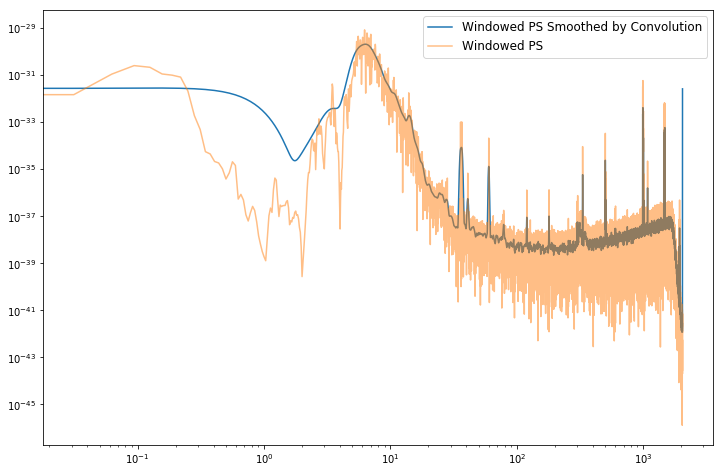

In [184]:
plt.loglog(nu,N_h,label='Windowed PS Smoothed by Convolution')
plt.loglog(nu,ps_h_w,alpha=0.5,label='Windowed PS')
plt.legend(fontsize='large')
plt.show()

Nice! Noise model matches the PS well. I haven't dealt with the lines, but I *think* this is okay: those lines are real noise in the system, and so I believe I would want to capture them with my noise model. Check out Livingston as well:

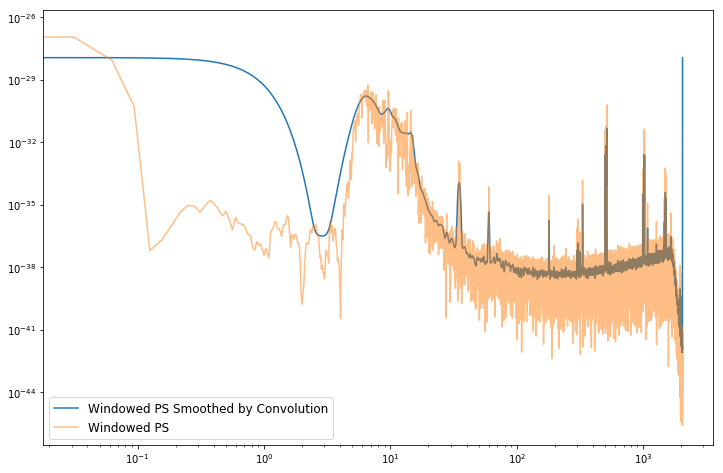

In [185]:
plt.loglog(nu,N_l,label='Windowed PS Smoothed by Convolution')
plt.loglog(nu,ps_l_w,alpha=0.5,label='Windowed PS')
plt.legend(fontsize='large')
plt.show()

Again, the important spectral information here is retained in the smoothed noise estimation. Now I want to figure out what frequencies I want to cut off: based on the powerful noise below ~20Hz in the Livingston model, let's just axe the frequencies below 20Hz. Now let's figure out where that garbage noise at the end starts by looking on a linear frequency scale:

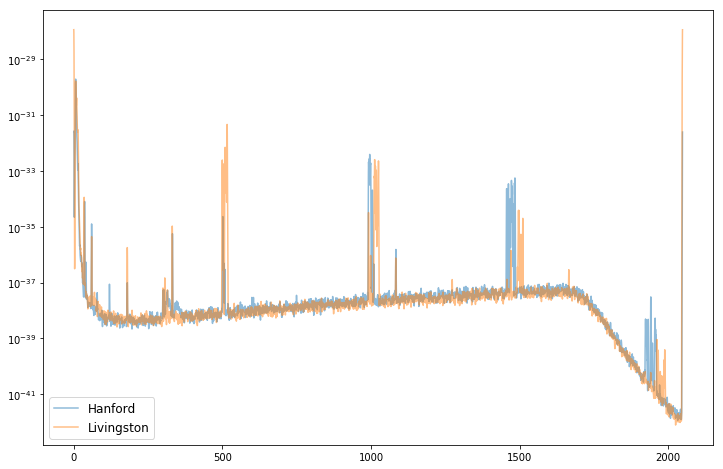

In [186]:
plt.semilogy(nu,N_h,alpha=0.5,label='Hanford')
plt.semilogy(nu,N_l,alpha=0.5,label='Livingston')
plt.legend(fontsize='large')
plt.show()

Looks like after ~1600 Hz is garbage. I'll get rid of that too.

By setting $N^{-1/2}$ in those bad regions to 0, effectively ignoring them.

In [187]:
N_h_inv_sqrt = 1/np.sqrt(N_h)
N_h_inv_sqrt[nu<20] = 0
N_h_inv_sqrt[nu>1600] = 0

N_l_inv_sqrt = 1/np.sqrt(N_l)
N_l_inv_sqrt[nu<20] = 0
N_l_inv_sqrt[nu>1600] = 0

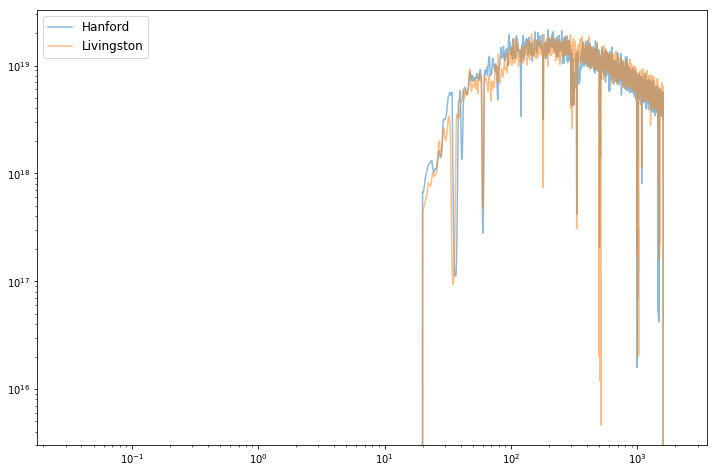

In [228]:
plt.loglog(nu,N_h_inv_sqrt,alpha=0.5,label='Hanford')
plt.loglog(nu,N_l_inv_sqrt,alpha=0.5,label='Livingston')
plt.legend(fontsize='large')
plt.show()

In [188]:
strain_h_ft_whitened = strain_h_ft_w*N_h_inv_sqrt
strain_h_whitened = np.fft.irfft(strain_h_ft_whitened)
strain_l_ft_whitened = strain_l_ft_w*N_l_inv_sqrt
strain_l_whitened = np.fft.irfft(strain_l_ft_whitened)
template_h_ft = np.fft.rfft(template_h)
template_l_ft = np.fft.rfft(template_l)
template_h_whitened = np.fft.irfft(template_h_ft*N_h_inv_sqrt)
template_l_whitened = np.fft.irfft(template_l_ft*N_l_inv_sqrt)

Check out the whitened templates:

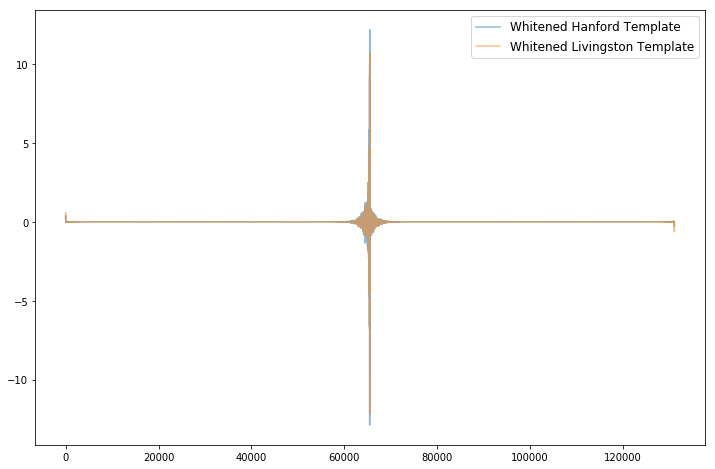

In [189]:
plt.plot(template_h_whitened,alpha=0.5,label='Whitened Hanford Template')
plt.plot(template_l_whitened,alpha=0.5,label='Whitened Livingston Template')
plt.legend(fontsize='large')
plt.show()

So with pre-whitening applied, it looks like we'll find our signal with the most strength near the merger, where the frequencies there play nicely with the noise from Hanford/Livingston.

### Part B:

Now, we use the matched filter method to find the signal in Hanford and Livingston! Since we have done the step of pre-whitening, the matched filter process is simply a correlation between the pre-whitened strain and pre-whitened template.

In [190]:
matched_filt_h_ft = strain_h_ft_whitened*np.conj(template_h_ft*N_h_inv_sqrt)
matched_filt_h = np.fft.irfft(matched_filt_h_ft)

matched_filt_l_ft = strain_l_ft_whitened*np.conj(template_l_ft*N_l_inv_sqrt)
matched_filt_l = np.fft.irfft(matched_filt_l_ft)

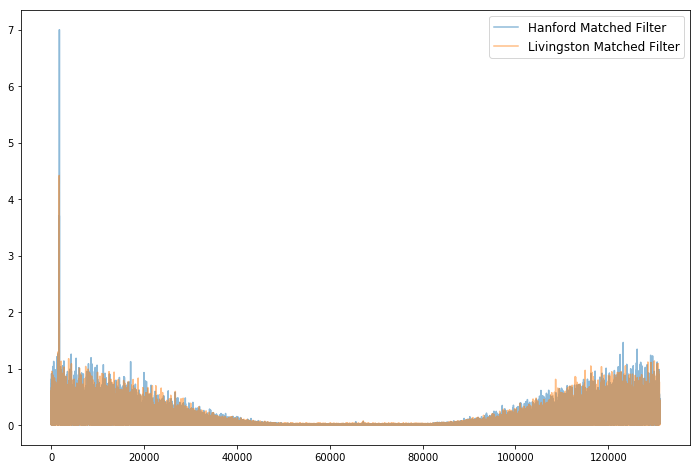

In [191]:
plt.plot(abs(matched_filt_h),alpha=0.5,label='Hanford Matched Filter')
plt.plot(abs(matched_filt_l),alpha=0.5,label='Livingston Matched Filter')
#plt.plot(abs(matched_filt_h)+abs(matched_filt_l),alpha=0.5,label='Combined Matched Filter')
plt.legend(fontsize='large')
plt.show()

In [ ]:
plt.loglog()

### Part C

Nice, can clearly see the matched filter does best at a slight template offset forwards in time from its original position. I plotted the absolute value because I think its the absolute value of the matched filter output we care about. To turn this into an SNR, I'm going to take a RMS for the matched filter region slightly after the peak signal, and divide out the RMS from the matched filter signal.

In [192]:
rms_h = np.std(matched_filt_h[np.argmax(matched_filt_h)+100:np.argmax(matched_filt_h)+1100])
rms_l = np.std(matched_filt_h[np.argmax(matched_filt_l)+100:np.argmax(matched_filt_l)+1100])

SNR_h = abs(matched_filt_h)/rms_l
SNR_l = abs(matched_filt_l)/rms_l

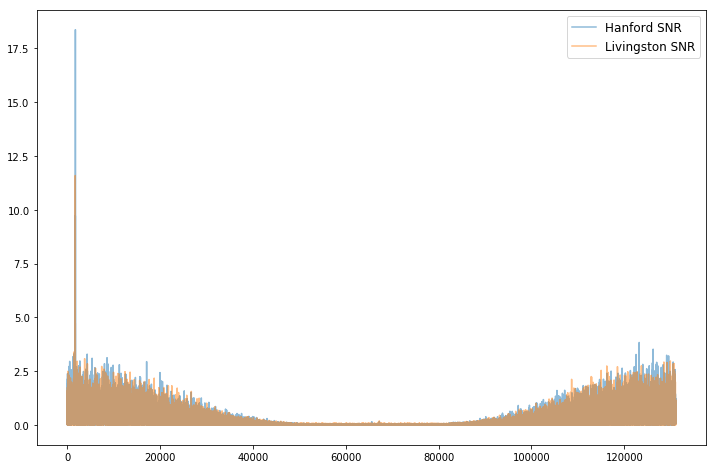

Hanford SNR: 18.37
Livingston SNR: 11.59


In [193]:
plt.plot(SNR_h,alpha=0.5,label='Hanford SNR')
plt.plot(SNR_l,alpha=0.5,label='Livingston SNR')
plt.legend(fontsize='large')
plt.show()
print('Hanford SNR: %.2f' % SNR_h.max())
print('Livingston SNR: %.2f' % SNR_l.max())

To combine the Livingston and Hanford events: I'm going to roll the Livingston event's max matched filter signal to overlap Hanford's (as the wave reached Livingston very slightly earlier, to do with the travel time of the waves near the speed of light), and then follow the same RMS estimation procedure for SNR

In [194]:
matched_filt_l_align = np.roll(matched_filt_l,np.argmax(abs(matched_filt_h)) - np.argmax(abs(matched_filt_l)))
#_c for combined
matched_filt_c = abs(matched_filt_h) + abs(matched_filt_l_align)
#I feel like I can't find rms taking the absolute value of the matched filter
#as that biases the rms low, since signals become closer together. So I'll make
#a separate array to calculate the rms
matched_filt_c_rms = matched_filt_h + matched_filt_l_align

rms_c = np.std(matched_filt_c_rms[np.argmax(matched_filt_c_rms)+100:np.argmax(matched_filt_c_rms)+1100])
SNR_c = matched_filt_c/rms_c

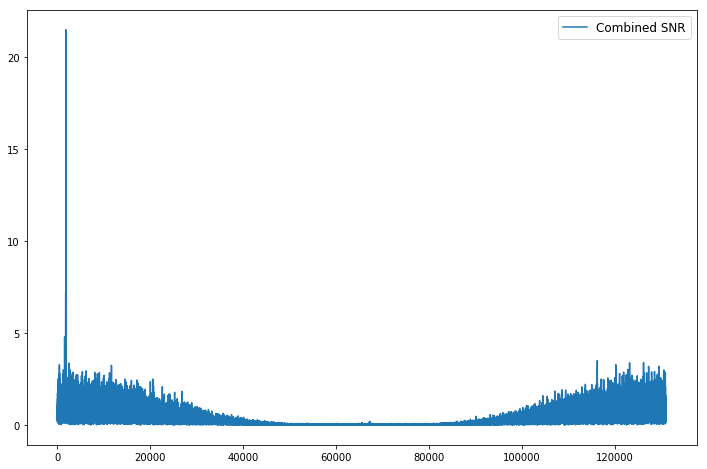

Combined SNR: 21.48


In [195]:
plt.plot(SNR_c,label='Combined SNR')
plt.legend(fontsize='large')
plt.show()
print('Combined SNR: %.2f' % (SNR_c.max()))

### Part D

Based on template and noise estimate, find the frequency where half the weight comes from above that frequency and half the weight comes from below... Power spectrum of matched filter?

In [256]:
matched_filt_h_ps = abs(np.fft.rfft(matched_filt_h))**2
matched_filt_l_ps = abs(np.fft.rfft(matched_filt_l))**2

On second thought I don't think that makes sense. The pre-whitened template shows me that I get a ton of signal from the high frequencies. If I take the PS of those whitened templates, I should see spikes in frequency space at the frequencies where I get a lot of signal. So, if I add up all the power until I reach half of the total power, then that tells me the frequency where half the power comes from below and half from above. I think what this should give a rough estimate of the frequency the two black holes orbit near merger.

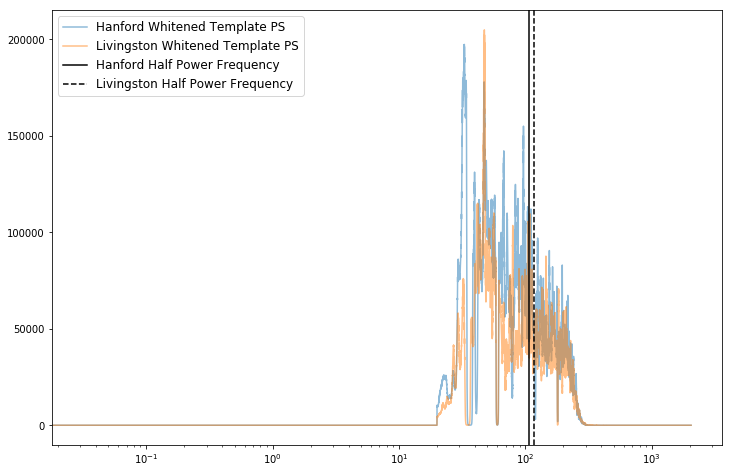

Hanford Half Power Frequency: 106.94 Hz
Livingston Half Power Frequency: 117.56 Hz


In [290]:
template_h_ps = abs(np.fft.rfft(template_h_whitened))**2
template_l_ps = abs(np.fft.rfft(template_l_whitened))**2

cumsum_h = np.cumsum(template_h_ps)
cumsum_l = np.cumsum(template_l_ps)

ind_h = np.argmin(abs(cumsum_h - template_h_ps.sum()/2.))
ind_l = np.argmin(abs(cumsum_l - template_l_ps.sum()/2.))

plt.semilogx(nu,template_h_ps,alpha=0.5,label='Hanford Whitened Template PS')
plt.semilogx(nu,template_l_ps,alpha=0.5,label='Livingston Whitened Template PS')
plt.axvline(nu[ind_h],ls='-',label='Hanford Half Power Frequency',c='k')
plt.axvline(nu[ind_l],ls='--',label='Livingston Half Power Frequency',c='k')
plt.legend(fontsize='large')
plt.show()
print('Hanford Half Power Frequency: %.2f Hz' % (nu[ind_h]))
print('Livingston Half Power Frequency: %.2f Hz' % (nu[ind_l]))

In [295]:
print(template_h_ps[ind_h:].sum())
print(template_h_ps[0:ind_h].sum())

202185514.87089983
202080745.89923632


In [297]:
print(template_l_ps[ind_l:].sum())
print(template_l_ps[0:ind_l].sum())

162049943.50719726
161952100.07947087


Just playing around...

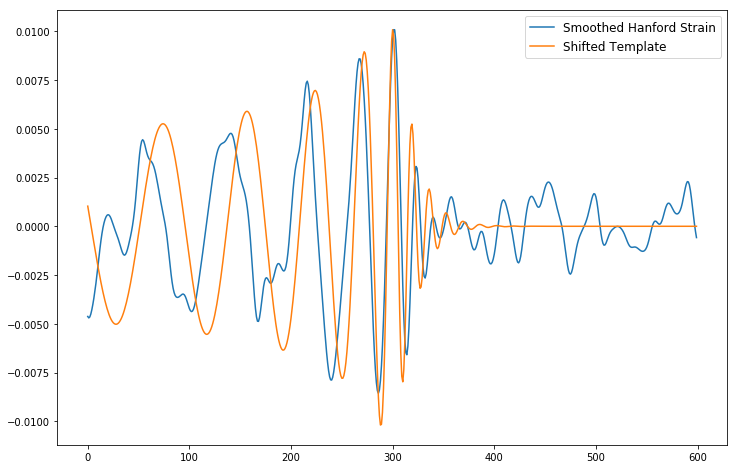

In [255]:
n = len(strain_h)
x = np.arange(n)
fwhm = 10
x[int(n/2):] = x[int(n/2):] - n
sigma = fwhm/(2*np.sqrt(2*np.log(2)))
smooth_fnc = np.exp(-x**2/(2*sigma**2))
smooth_fnc = smooth_fnc/np.sum(smooth_fnc)

smoothed_strain_h_whitened = np.fft.irfft(np.fft.rfft(strain_h_whitened)*np.fft.rfft(smooth_fnc))
ind = np.argmax(matched_filt_h)+np.argmax(template_h_whitened)
scale_factor = smoothed_strain_h_whitened.max()/template_h.max()

plt.plot(smoothed_strain_h_whitened[ind-300:ind+300],label='Smoothed Hanford Strain')
plt.plot(np.roll(template_h*scale_factor,np.argmax(matched_filt_h))[ind-300:ind+300],label='Shifted Template')
plt.legend(fontsize='large')
plt.show()

# Appended Notes for my own reference!

# Questions to ask:

1. Don't entirely understand how we get our frequencies
2. What makes a good choice of window function? Low 'spectral leakage'?
3. Estimating noise? Don't understand the whole N$^{1/2}$ thing
4. The logic of pre-whitening is going way over head: need explanation.
5. When I made my whitened strain, when I accidentally didn't use the windowed strain fourier transform to calculate it, I ended up with something weird: what was going on there? Why did the window change it so much?

# Answers:

1. plot the first mode. What's the period? Frequency is 1/Period.
2. Low spectral leakage yes, but tradeoff with the FWHM of the FT of the window. 'Throw out' more data
3. Multiplication in fourier space is convolution in real space. The noise is the average power (of some width given by smoothing). In time space have so much frequency structure. In frequency space has same information. Uncorrelated noise in frequency space. Look at a small chunk of the strain in real space: you'll see this! Solve the Ninv thing: get answer for m in units of amplitude over how much you moved the filter?? Matched filter noise on the right (signal to latch onto on the left) Peak/RMS in some region gives a good estimate of S/N. Best fit amplitude for area of peak response and compare to noise where there's no response.